In [65]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import shap
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

import warnings
import gc
#warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, StandardScaler

data = pd.read_csv("./10feature_cpu.csv")
col = list(map(str, data.columns))
x = data[col[:-1]]
y = data[col[-1]]

scaler = MinMaxScaler()
#dscaler = scaler.fit(x)
#x = dscaler.transform(x)
#y = y.to_numpy()
x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
#test_data_size = 40
#x_train, x_test = x[:-test_data_size], x[-test_data_size:]
#y_train, y_test = y[:-test_data_size], y[-test_data_size:]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test, test_size=0.5)
#x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=0)

model = LGBMRegressor(objective='regression', num_iterations=10**5)
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
val_pred = model.predict(x_val)
score = rmse_expm1(val_pred, y_val)
score



Found `num_iterations` in params. Will use it instead of argument


-0.20572993969135434

In [61]:
def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def evaluate(x_data, y_data):
    model = LGBMRegressor(objective='regression', num_iterations=10**5)
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
    val_pred = model.predict(x_val)
    score = rmse_expm1(val_pred, y_val)
    return score

def rfe(x_data, y_data, method, ratio=0.9, min_feats=40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:
        model = LGBMRegressor(objective='regression', num_iterations=10**5)
        #model = RandomForestClassifier(n_estimators=100, random_state=0)
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=0)
        model.fit(x_train, y_train)
        val_pred = model.predict(x_val)
        score = rmse_expm1(val_pred, y_val)
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': 'model', 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        if method == 'basic':
            feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
            #print(feat_imp)
        elif method == 'perm':
            perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
            feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'shap':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(x_data[feats])
            feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    #print(feat_imp)
    #return archive
    return feat_imp

feats = [col for col in data.columns if col != 'fault']
len(feats)

###LGBMRegressor  얘는 퍼센티지 합산1로 안나옴
## 스코어 -> feat_imp값으로 바꾸거나 print(feat_imp) 필요

10

In [56]:
%%time
basic_archive = rfe(x, y, 'basic')
#print('a')
print(basic_archive)
#basic_archive.shape

10 -0.12988989715497087
node_schedstat_running_seconds_total    0.303984
node_cpu_seconds_total                  0.266167
node_schedstat_waiting_seconds_total    0.177553
process_cpu_seconds_total               0.105110
node_cpu_scaling_frequency_hertz        0.066249
node_schedstat_timeslices_total         0.030927
node_procs_running                      0.019859
node_memory_Active_anon_bytes           0.015784
node_memory_MemFree_bytes               0.013724
node_memory_Unevictable_bytes           0.000644
dtype: float64
CPU times: user 188 ms, sys: 16 ms, total: 204 ms
Wall time: 200 ms


In [57]:
feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
for i in range(10):
    print(i, evaluate(data[feat_imp.iloc[:i].index], data['fault']))

Found `num_iterations` in params. Will use it instead of argument


0 -0.7589060889132405
1 -0.2643994726500434
2 -0.11761299396876393
3 -0.13870781512796804
4 -0.13453956697124744
5 -0.13704277786666993
6 -0.14026192641912127
7 -0.13793656335992224
8 -0.14093714250367875
9 -0.1424237268466996


In [58]:
%%time
perm_archive = rfe(x, y, 'perm')
rfe(x, y, 'perm')

10 -0.12988989715497087
10 -0.12988989715497087
CPU times: user 1.29 s, sys: 20 ms, total: 1.31 s
Wall time: 1.31 s


node_cpu_seconds_total                  0.140000
node_schedstat_running_seconds_total    0.064000
node_memory_Active_anon_bytes           0.002286
node_cpu_scaling_frequency_hertz        0.002286
node_schedstat_waiting_seconds_total    0.001143
node_schedstat_timeslices_total         0.000571
process_cpu_seconds_total               0.000571
node_procs_running                      0.000000
node_memory_Unevictable_bytes           0.000000
node_memory_MemFree_bytes              -0.000571
dtype: float64

In [59]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(x_train, y_train)
perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
perm_feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
#eli5.show_weights(perm)
eli5.show_weights(perm, top = 40, feature_names = x_train.columns.tolist())


Weight,Feature
0.1793 ± 0.0188,node_cpu_seconds_total
0.0164 ± 0.0097,node_schedstat_running_seconds_total
0.0107 ± 0.0078,node_schedstat_waiting_seconds_total
0.0014 ± 0.0035,node_cpu_scaling_frequency_hertz
0 ± 0.0000,node_procs_running
0 ± 0.0000,node_memory_MemFree_bytes
0 ± 0.0000,node_schedstat_timeslices_total
0 ± 0.0000,process_cpu_seconds_total
0 ± 0.0000,node_memory_Active_anon_bytes
0 ± 0.0000,node_memory_Unevictable_bytes


In [11]:
for i in range(40, 90, 5):
    print(i, evaluate(data[perm_feat_imp.iloc[:i].index], data['fault']))

Found `num_iterations` in params. Will use it instead of argument


40 -0.14214891753456094
45 -0.14214891753456094
50 -0.14214891753456094
55 -0.14214891753456094
60 -0.14214891753456094
65 -0.14214891753456094
70 -0.14214891753456094
75 -0.14214891753456094
80 -0.14214891753456094
85 -0.14214891753456094


In [63]:
%%time
shap_archive = rfe(x, y, 'shap')
shap_archive

10 -0.13778999886461957
CPU times: user 1h 24min 26s, sys: 46.4 s, total: 1h 25min 13s
Wall time: 5min 26s


node_cpu_seconds_total                  0.250190
node_schedstat_running_seconds_total    0.137131
node_schedstat_waiting_seconds_total    0.032100
node_cpu_scaling_frequency_hertz        0.025466
process_cpu_seconds_total               0.023635
node_memory_Active_anon_bytes           0.016130
node_memory_MemFree_bytes               0.015190
node_schedstat_timeslices_total         0.011505
node_procs_running                      0.005667
node_memory_Unevictable_bytes           0.005293
dtype: float64

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


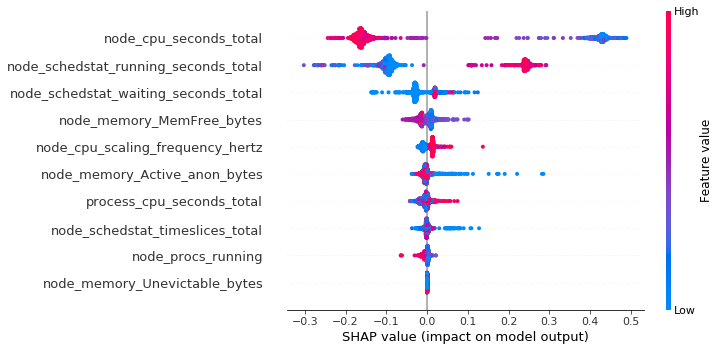

In [66]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
shap.summary_plot(shap_values, x)

In [14]:
for i in range(40, 90, 5):
    print(i, evaluate(data[shap_feat_imp.iloc[:i].index], data['fault']))

40 -0.14214891753456094
45 -0.14214891753456094
50 -0.14214891753456094
55 -0.14214891753456094
60 -0.14214891753456094
65 -0.14214891753456094
70 -0.14214891753456094
75 -0.14214891753456094
80 -0.14214891753456094
85 -0.14214891753456094


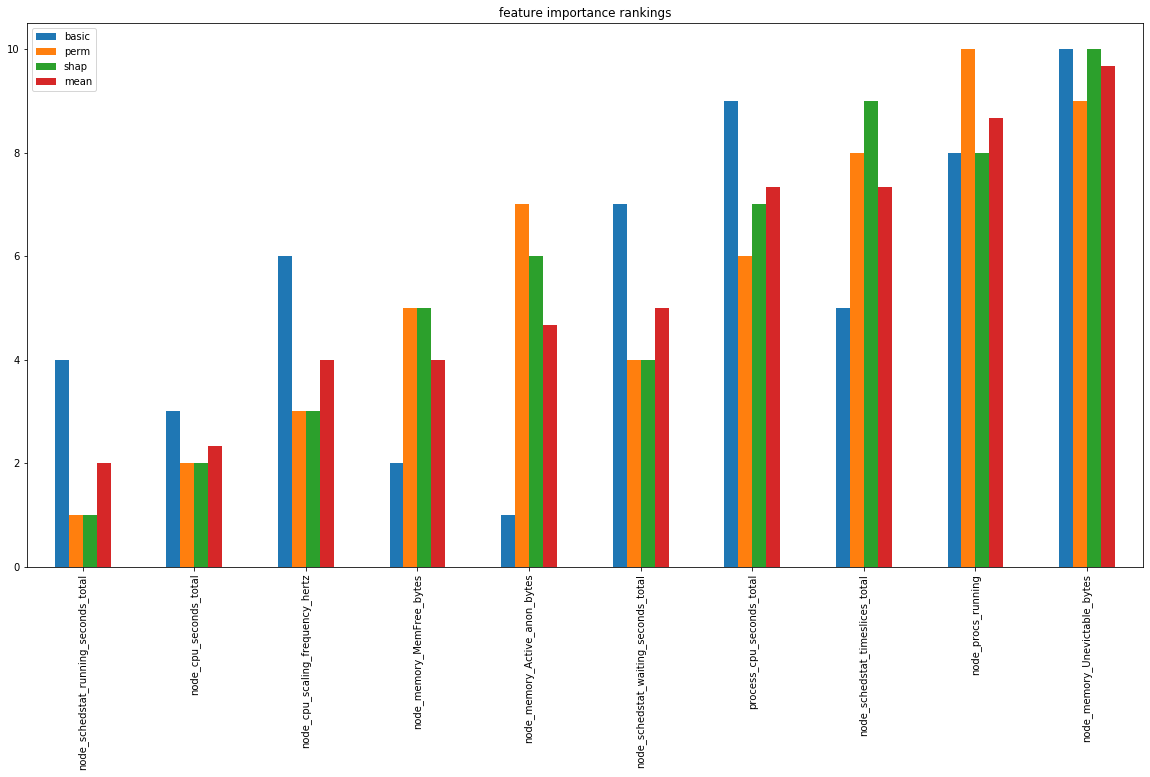

In [15]:
feat_imp_archive = pd.DataFrame(index=feats, columns=['basic', 'perm', 'shap', 'mean'])
feat_imp_archive['basic'] = feat_imp.rank(ascending=False)
feat_imp_archive['perm'] = perm_feat_imp.rank(ascending=False)
feat_imp_archive['shap'] = shap_feat_imp.rank(ascending=False)
feat_imp_archive['mean'] = feat_imp_archive[['basic', 'perm', 'shap']].mean(axis=1)
feat_imp_archive = feat_imp_archive.sort_values('mean')
feat_imp_archive[feat_imp_archive['mean']<20].plot(kind='bar', figsize=(20, 10), title='feature importance rankings');

In [16]:
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp_archive.iloc[:i].index], data['fault']))

Found `num_iterations` in params. Will use it instead of argument


40 -0.14214891753456094
45 -0.14214891753456094
50 -0.14214891753456094
55 -0.14214891753456094
60 -0.14214891753456094
65 -0.14214891753456094
70 -0.14214891753456094
75 -0.14214891753456094
80 -0.14214891753456094
85 -0.14214891753456094


In [17]:
%%time
rf = RandomForestRegressor(n_jobs=-1, n_estimators=200, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=0)
feat_selector.fit(data[feats].values, data['fault'].values)

evaluate(data[np.array(feats)[feat_selector.support_]], data['fault'])

Found `num_iterations` in params. Will use it instead of argument


CPU times: user 1min 19s, sys: 6.56 s, total: 1min 25s
Wall time: 35.2 s


-0.14649081677125042